# Testing Kinetics Models

In [1]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack

In [2]:
# Constants


## Motivation
Consider a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``.

We initialize ``S1`` to 10. We expect that the following outcomes (designated by **On**):

- **O1**: ``S1`` decreases monotonically from 10 to 0.
- **O2**: ``S2`` increases initially, peaks, and then declises to 0.
- **O3**: ``S3`` increases monotonically to 10. 

Here is a first implementation of the model.

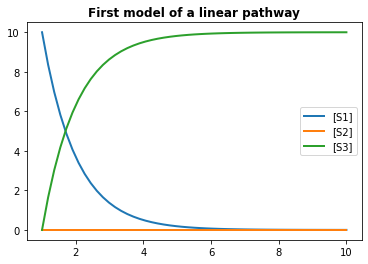

In [3]:
FIRST_IMPLEMENTATION = '''
R1: S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S1

S1 = 10
k1 = 1; k2 = 1
'''
rr = te.loada(FIRST_IMPLEMENTATION)
data = rr.simulate(1, 10)
rr.plot(data, title="First model of a linear pathway")

We see that O1 and O3 are satisfied. However, O2 is not. Why?

Looking carefully at the Antimony model, we see there is an error in the specification of the kinetics law for reaction ``R2``. The kinetics law incorrectly references ``S1`` instead of ``S2``. Below is the corrected model.

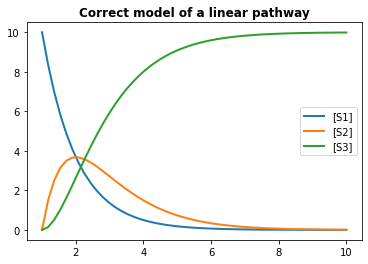

In [4]:
CORRECT_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2a: S2 -> S3; k2*S2

S1 = 10
k1 = 1; k2 = 1;
'''
rr = te.loada(CORRECT_MODEL)
data = rr.simulate(1, 10)
rr.plot(data, title="Correct model of a linear pathway")

In this model, all three outcomes are satisfied.

Although the example is simple, it demonstrates how easy it is to make mistakes in the construction of models, especially complex models. A few mistakes can be detected by tellurium, such as misspelling the name of a floating species. However, the mistake made in the first model, substituting ``S1`` for ``S2``, is not detected by Tellurium.

How do we detect errors in the implementation of models (a processing often referred to as *verification*)? By implementation of the model, we mean that there is a clear understanding of the expected behavior of the model. Verification is about providing ways to detect if the implemention provides the expected behavior.

Although our focus here is on verification, making sure that the intended model is what was built, there is another challenge in modeling. That is, choosing the corrrect model to implement.
Modellers address this by checking for correspondence between simulation data and laboratory measurements.
This process is called **validation**.
Both verification and validation are essential to producing useful models.
However, it makes no sense to validate a model that is implemented incorrectly.
Further, while there is considerable focus in the literature on model validation, there is almost no discussion of verification.

This chaper is about verifying simulation models, or verification testing.
Such testing is done by examining models and their outputs.
There are two kinds of verification tests.

The first kind of verification tests only examines the model itself; the model is not executed.
We refer to these as **static tests**.
For example, one static test is to look for suspicious kinetics laws, such as the kinetics law for ``R2``
that references a floating species that is neither a reactant nor a product (which would be incorrect
if the intended kinetics are mass action).
In the above example, 
Drawing on the experience of the software industry over the last 50 years,
we identify two kinds of validation.

The second kind of verification tests runs simulations and compares the results with what the model developer
expected.
This is illustrated by outcomes O1-O3 and our analysis of the above two simulation models.

The remainder of this chaper discusses static tests, dynamic tests, and provides a detailed example from BioModels.

## Static Testing

1. Relationship between static testing and software linters
1. Reactions have two parts, a **mass trasfer** expression and a **kinetics law**.
2. Errors in mass transfer
   1. Mass balance
   1. Blocked reactions
   1. Unreachable reactions
3. Errors in kinetics laws
   1. Incorrect reference to a chemical species
   1. negative valued 0th order kinetics

## Dynamic Testing

1. Relationship with unit tests. Looking for errors; not proving correctness.
1. Requirements for dynamic tests
   1. Predicates that describe expected behavior.
   1. Check the correspondence

Example 1: Linear pathway
1. Expanding the list of predicates
1. Code that automates testing the result

Example 2
1. Branched pathway
1. Develop the predicates
1. Code that tests for match

## Application to Glycolytic Oscillations

In [5]:
# Constants
WOLF_MODEL = "../common/models/Jana_WolfGlycolysis.antimony"
MOLECULES = ["Glucose", "fructose_1_6_bisphosphate", "glyceraldehyde_3_phosphate", "glycerate_3_phosphate",
            "pyruvate", "Acetyladehyde", "External_acetaldehyde", "ATP", "ADP", "NAD", "NADH"]
ENDTIME = 5
NUMPOINT = 100*ENDTIME
ROADRUNNER = te.loada(WOLF_MODEL)
DATA = ROADRUNNER.simulate(0, ENDTIME, NUMPOINT)

In [6]:

print(ROADRUNNER.getAntimony())

// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehy

In [7]:
 def getFft(molecule, data=DATA, offset=100, noZeroFreq=True):
    # Returns frequencies, abs(fft) for species
    col = "[%s]" % molecule
    values = data[col]
    numPoint = len(data)
    count = numPoint - offset
    endTime = data["time"][-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    if noZeroFreq:
        freqs = freqs[1:]
        fftValues = fftValues[1:]
    return freqs, fftValues

def getFfts(molecules, **kwargs):
    results = []
    for molecule in MOLECULES:
        _, fftValues = getFft(molecule, **kwargs)
        results.append(fftValues)
    return np.array(results)
   
def plotFft(molecule, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = getFft(molecule, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])

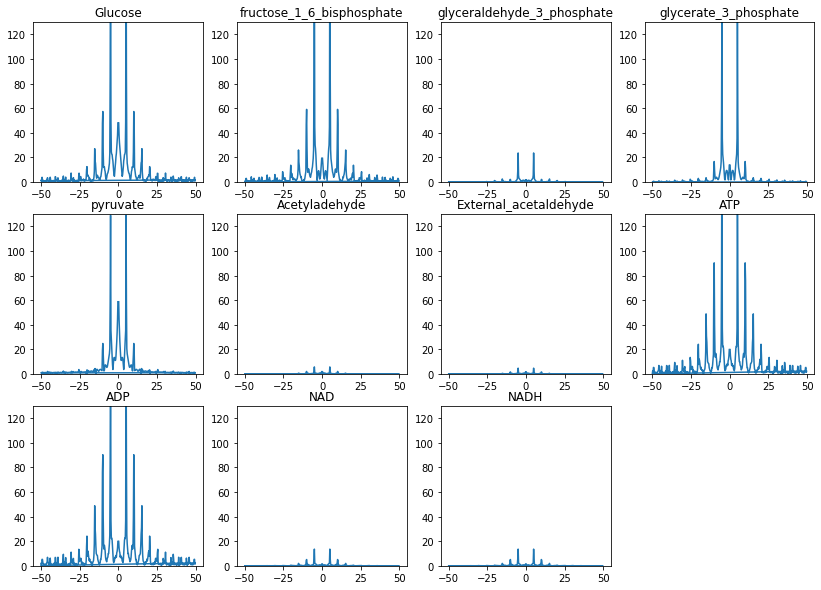

In [8]:
numCol = 4
numRow = 3
fig = plt.figure(figsize=(14,10))
for irow in range(numRow):
    for icol in range(numCol):
        idx = irow*numCol + icol
        if idx >= len(MOLECULES):
            break
        ax = plt.subplot2grid((numRow, numCol), (irow, icol), fig=fig)
        #ax = axes[irow, icol]
        plotFft(MOLECULES[idx], ax=ax)

In [9]:
_, v1 = getFft("Glucose")
_, v2 = getFft("glycerate_3_phosphate")
np.corrcoef([v1, v2])

array([[1.        , 0.95356603],
       [0.95356603, 1.        ]])

### Checking mass balance

### Checking for cyclic behavior